<a href="https://colab.research.google.com/github/guanyuq03/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Assignment%201/ECON_5200_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Phase 1: Prepare (Logic & Control Flow)**

In [1]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Spotify', 'Price_2016': 4.99, 'Price_2024': 5.99},
]

In [2]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
  rate = calculate_inflation(item["Price_2016"], item["Price_2024"])
  print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Spotify: 20.04% Inflation


**Phase 2: Process (The API Pipeline)**

Step 2.1: The "Data Proxy" Strategy

In [3]:
!pip install fredapi

In [4]:
from fredapi import Fred
import pandas as pd

In [5]:
fred = Fred(api_key='b46359d978b6550ab8cad23783c4ba65')

In [6]:
# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
food = fred.get_series('CUSR0000SEFV')
streaming = fred.get_series('CUSR0000SERA02')

Step 2.2: Normalization Logic

In [7]:
# Combine all CPI-related series into one DataFrame
df = pd.DataFrame({
    'CPI': official_cpi,
    'Tuition': tuition,
    'Rent': rent,
    'Food': food,
    'Streaming': streaming,
})
# Keep only the rows where all series have data
df_common = df.dropna(subset=["CPI", "Tuition", "Rent", "Food", "Streaming"])
# Define the base date for normalization
start_date = "2016-01-01"
start_values = df_common.loc[start_date]
# Normalize all series so that each index equals 100 in 2016
value_index = (df_common / start_values) * 100

**Phase 3: Analyze (The Index Theory & Visualization)**

Step 3.1: Visualizing Raw Components

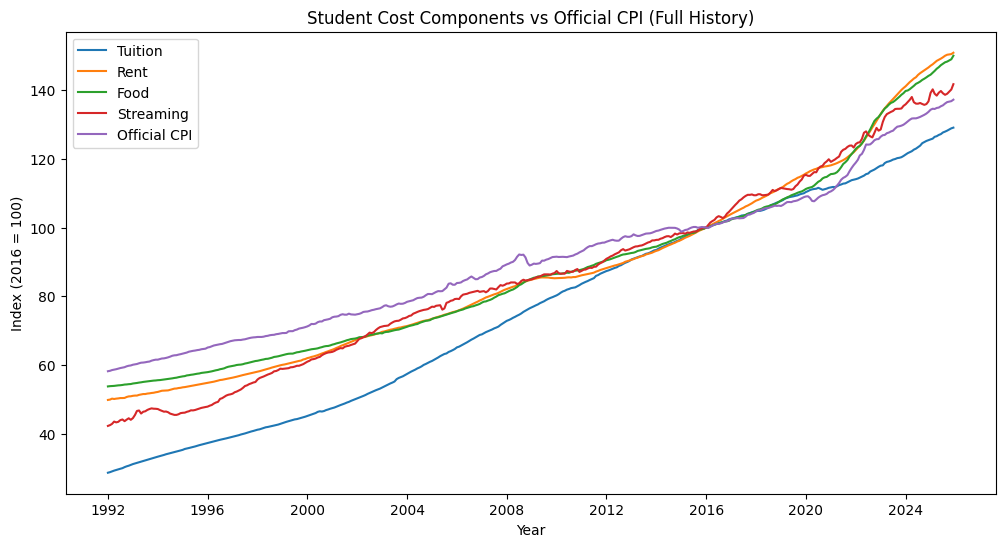

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(value_index.index, value_index["Tuition"], label="Tuition")
plt.plot(value_index.index, value_index["Rent"], label="Rent")
plt.plot(value_index.index, value_index["Food"], label="Food")
plt.plot(value_index.index, value_index["Streaming"], label="Streaming")
plt.plot(value_index.index, value_index["CPI"], label="Official CPI")
plt.xlabel("Year")
plt.ylabel("Index (2016 = 100)")
plt.title("Student Cost Components vs Official CPI (Full History)")
plt.legend()
plt.show()

Step 3.2: The Weighted "Studnet SPI" (Honest Chart)

In [9]:
# Define a weight dictionary
weights = {'Tuition': 0.4, 'Rent': 0.3, 'Food': 0.2, 'Streaming': 0.1}

In [10]:
# Calculate a new column
value_index["Student_SPI"] = (
    weights["Tuition"] * value_index["Tuition"]
    + weights["Rent"] * value_index["Rent"]
    + weights["Food"] * value_index["Food"]
    + weights["Streaming"] * value_index["Streaming"]
)

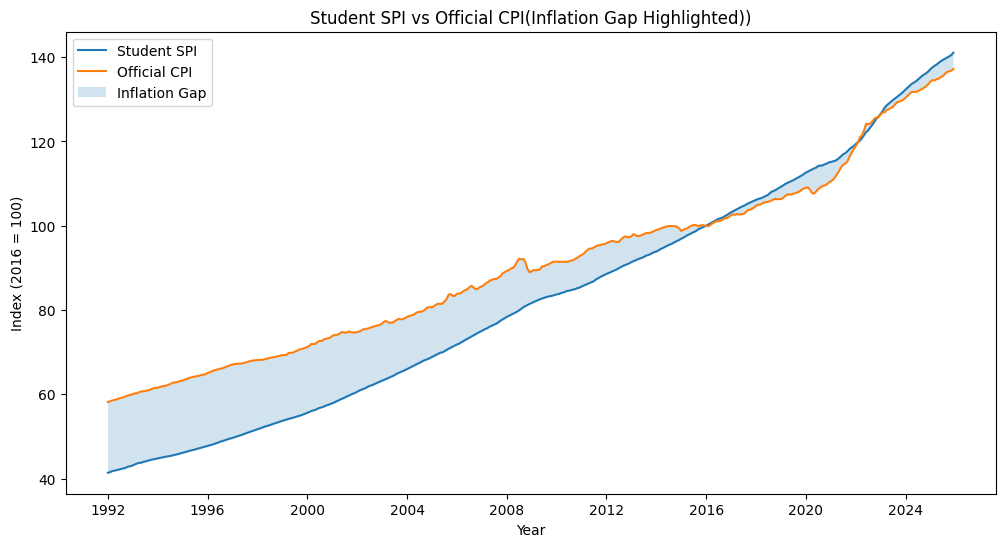

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(value_index.index, value_index["Student_SPI"], label="Student SPI")
plt.plot(value_index.index, value_index["CPI"], label="Official CPI")
plt.fill_between(value_index.index, value_index["Student_SPI"], value_index["CPI"], alpha=0.2, label="Inflation Gap")
plt.xlabel("Year")
plt.ylabel("Index (2016 = 100)")
plt.title("Student SPI vs Official CPI(Inflation Gap Highlighted))")
plt.legend()
plt.show()

Step 3.3: The Scale Fallacy (Why We Normalize)

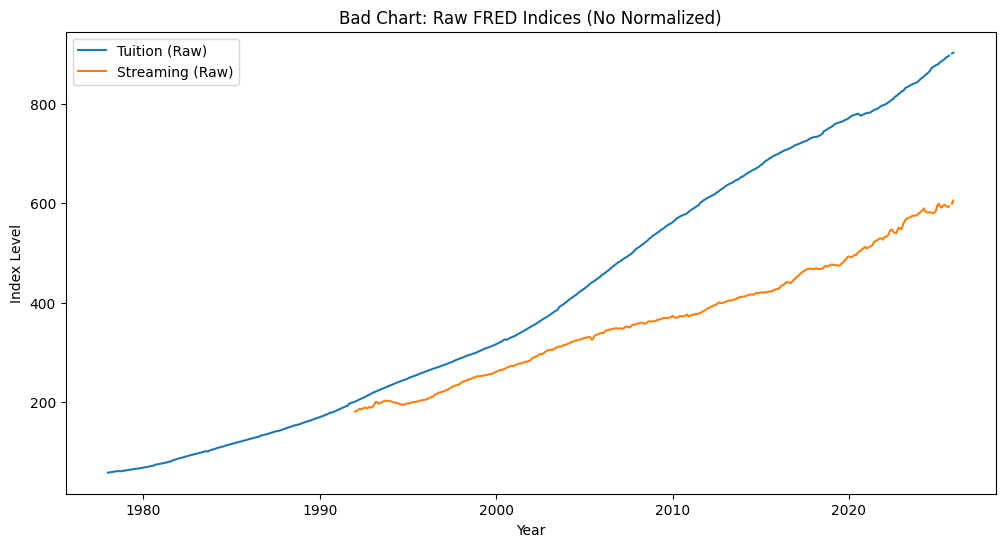

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Tuition'], label='Tuition (Raw)')
plt.plot(df.index, df['Streaming'], label='Streaming (Raw)')

plt.title('Bad Chart: Raw FRED Indices (No Normalized)')
plt.xlabel('Year')
plt.ylabel('Index Level')
plt.legend()
plt.show()

Step 3.3 Explanation of why comparing raw indices with different base years is a "Data Crime":

It is a data crime to compare raw indices with different base years since it mixes numbers that are on different scales, which can lead to wrong visual comparisons and false conclusions.

The chart is inappropriate because the two CPI series are using different base years. For tuition, the index is based on an older year such as 1982-1984, while streaming uses a later base year such as 2002. In this case, the same value "100" does not mean the same thing for the two series. Therefore, tuition appears very large and streaming looks smaller. This does not mean that tuition inflated more or is more important, and the different comes mostly from how the indices are constructed, not from real price changes.

**Phase 4: AI Expansion (The Co-Pilot Era)**

Task 4.1

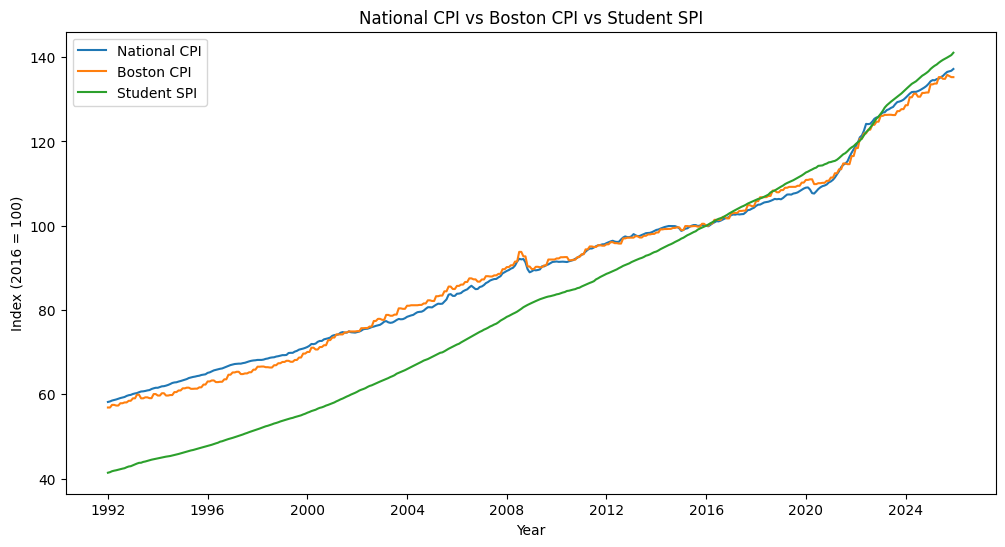

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Boston-Cambridge-Newton CPI-U (All Items) FRED series code
BOSTON_CODE = "CUURA103SA0"

# 1) Fetch Boston CPI (raw)
boston_raw = fred.get_series(BOSTON_CODE)
boston_raw.index = pd.to_datetime(boston_raw.index)

# 2) Align Boston CPI to your normalized index timeline
# (Boston series can be bimonthly, so we forward-fill missing months)
boston_aligned = boston_raw.reindex(value_index.index).ffill()

# 3) Normalize Boston CPI to 2016 = 100 (same base as your value_index)
base_date = pd.Timestamp("2016-01-01")
base_value = boston_aligned.loc[base_date]

# Just in case 2016-01 is missing, fall back to first available month in 2016
if pd.isna(base_value):
    base_value = boston_aligned.loc["2016"].dropna().iloc[0]

boston_index = (boston_aligned / base_value) * 100

# 4) Add to your normalized table
value_index["Boston_CPI"] = boston_index

# 5) Plot: National CPI vs Boston CPI vs Student SPI
plt.figure(figsize=(12, 6))
plt.plot(value_index.index, value_index["CPI"], label="National CPI")
plt.plot(value_index.index, value_index["Boston_CPI"], label="Boston CPI")
plt.plot(value_index.index, value_index["Student_SPI"], label="Student SPI")

plt.xlabel("Year")
plt.ylabel("Index (2016 = 100)")
plt.title("National CPI vs Boston CPI vs Student SPI")
plt.legend()
plt.show()

Task 4.2: The Digital Portfolio (AI-Written README)

In [14]:
# Select the most recent observation
latest = value_index.dropna().iloc[-1]

# Calculate the percentage divergence
divergence_pct = ((latest["Student_SPI"] - latest["CPI"])
                  / latest["CPI"]) * 100

divergence_pct

np.float64(2.8115172779868276)

Github Link: https://github.com/guanyuq03/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Assignment%201/README.md